## Lesson 12.6 - Seaborn: Plotting on data-aware grids

*Facsimile of [Seaborn tutorial](http://stanford.edu/~mwaskom/software/seaborn/tutorial.html).*

When exploring medium-dimensional data, a useful approach is to draw multiple instances of the same plot on different subsets of your dataset. This technique is sometimes called either "lattice", or `"trellis" <http://netlib.bell-labs.com/cm/ms/departments/sia/project/trellis>`_ plotting, and it is related to the idea of `"small multiples" <http://en.wikipedia.org/wiki/Small_multiple>`_. It allows a viewer to quickly extract a large amount of information about complex data. Matplotlib offers good support for making figures with multiple axes; seaborn builds on top of this to directly link the structure of the plot to the structure of your dataset.

To use these features, your data has to be in a Pandas DataFrame and it must take the form of what Hadley Whickam calls `"tidy" data <http://vita.had.co.nz/papers/tidy-data.pdf>`_. In brief, that means your dataframe should be structured such that each column is a variable and each row is an observation.

For advanced use, you can use the objects discussed in this part of the tutorial directly, which will provide maximum flexibility. Some seaborn functions (such as `lmplot`, `factorplot`, and `pairplot`) also use them behind the scenes. Unlike other seaborn functions that are "Axes-level" and draw onto specific (possibly already-existing) matplotlib ``Axes`` without otherwise manipulating the figure, these higher-level functions create a figure when called and are generally more strict about how it gets set up. In some cases, arguments either to those functions or to the constructor of the class they rely on will provide a different interface attributes like the figure size, as in the case of `lmplot` where you can set the height and aspect ratio for each facet rather than the overall size of the figure. Any function that uses one of these objects will always return it after plotting, though, and most of these objects have convenience methods for changing how the plot, often in a more abstract and easy way.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
sns.set(style="ticks")
np.random.seed(sum(map(ord, "axis_grids")))

Subsetting data with `FacetGrid`
---------------------------------------

The `FacetGrid` class is useful when you want to visualize the distribution of a variable or the relationship between multiple variables separately within subsets of your dataset. A `FacetGrid` can be drawn with up to three dimensions: ``row``, ``col``, and ``hue``. The first two have obvious correspondence with the resulting array of axes; think of the hue variable as a third dimension along a depth axis, where different levels are plotted with different colors.

The class is used by initializing a `FacetGrid` object with a dataframe and the names of the variables that will form the row, column, or hue dimensions of the grid. These variables should be categorical or discrete, and then the data at each level of the variable will be used for a facet along that axis. For example, say we wanted to examine differences between lunch and dinner in the ``tips`` dataset.

Additionally, both `lmplot` and `factorplot` use this object internally, and they return the object when they are finsihed so that it can be used for further tweaking.

In [4]:
tips = sns.load_dataset("tips")

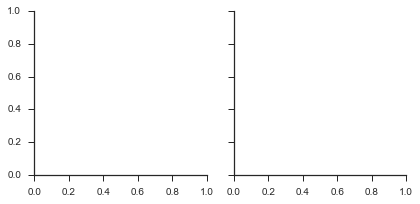

In [5]:
g = sns.FacetGrid(tips, col="time")

Initializing the grid like this sets up the matplotlib figure and axes, but doesn't draw anything on them.

The main approach for visualizing data on this grid is with the :meth:`FacetGrid.map` method. Provide it with a plotting function and the name(s) of variable(s) in the dataframe to plot. Let's look at the distribution of tips in each of these subsets, using a histogram.

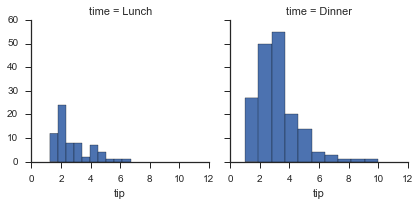

In [6]:
g = sns.FacetGrid(tips, col="time")
g.map(plt.hist, "tip")

This function will draw the figure and annotate the axes, hopefully producing a finished plot in one step. To make a relational plot, just pass multiple variable names. You can also provide keyword arguments, which will be passed to the plotting function:

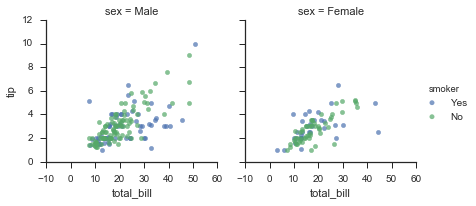

In [7]:
g = sns.FacetGrid(tips, col="sex", hue="smoker")
g.map(plt.scatter, "total_bill", "tip", alpha=.7)
g.add_legend()

There are several options for controlling the look of the grid that can be passed to the class constructor.

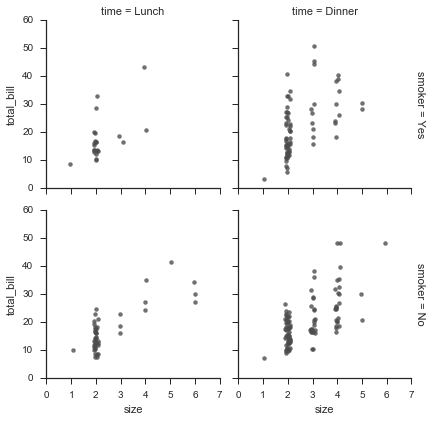

In [8]:
g = sns.FacetGrid(tips, row="smoker", col="time", margin_titles=True)
g.map(sns.regplot, "size", "total_bill", color=".3", fit_reg=False, x_jitter=.1)

Note that ``margin_titles`` isn't formally supported by the matplotlib API, and may not work well in all cases. In particular, it currently can't be used with a legend that lies outside of the plot.

The size of the figure is set by providing the height of *each* facet, along with the aspect ratio:

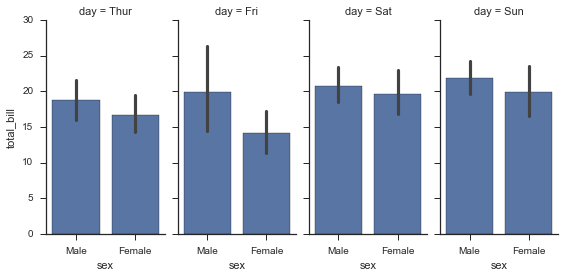

In [9]:
g = sns.FacetGrid(tips, col="day", size=4, aspect=.5)
g.map(sns.barplot, "sex", "total_bill")

With versions of matplotlib > 1.4, you can pass parameters to be used in the `gridspec` module. The can be used to draw attention to a particular facet by increasing its size. It's particularly useful when visualizing distributions of datasets with unequal numbers of groups in each facet.

/Volumes/Files/App/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


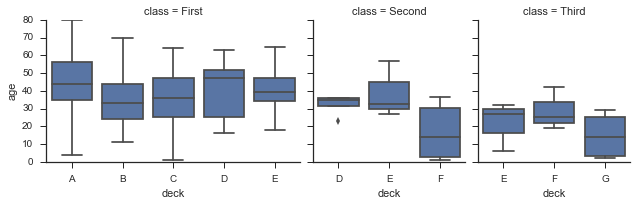

In [11]:
titanic = sns.load_dataset("titanic")
titanic = titanic.assign(deck=titanic.deck.astype(object)).sort("deck")
g = sns.FacetGrid(titanic, col="class", sharex=False,
                  gridspec_kws={"width_ratios": [5, 3, 3]})
g.map(sns.boxplot, "deck", "age")

The default ordering of the facets is derived from the information in the DataFrame. If the variable used to define facets has a categorical type, then the order of the categories is used. Otherwise, the facets will be in the order of appearence of the category levels. It is possible, however, to specify an ordering of any facet dimension with the appropriate ``*_order`` parameter:

/Volumes/Files/App/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


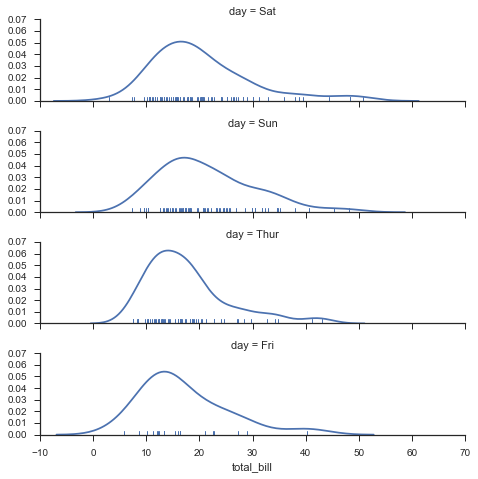

In [12]:
ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(tips, row="day", row_order=ordered_days,
                  size=1.7, aspect=4,)
g.map(sns.distplot, "total_bill", hist=False, rug=True)

Any seaborn color palette (i.e., something that can be passed to `color_palette()` can be provided. You can also use a dictionary that maps the names of values in the ``hue`` variable to valid matplotlib colors:

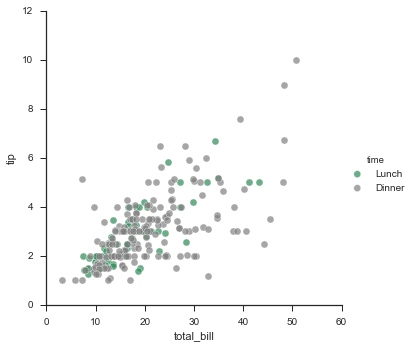

In [13]:
pal = dict(Lunch="seagreen", Dinner="gray")
g = sns.FacetGrid(tips, hue="time", palette=pal, size=5)
g.map(plt.scatter, "total_bill", "tip", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend()

You can also let other aspects of the plot vary across levels of the hue variable, which can be helpful for making plots that will be more comprehensible when printed in black-and-white. To do this, pass a dictionary to ``hue_kws`` where keys are the names of plotting function keyword arguments and values are lists of keyword values, one for each level of the hue variable.

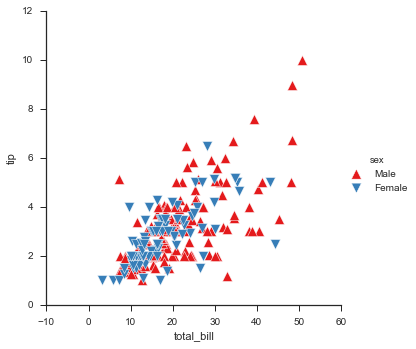

In [14]:
g = sns.FacetGrid(tips, hue="sex", palette="Set1", size=5, hue_kws={"marker": ["^", "v"]})
g.map(plt.scatter, "total_bill", "tip", s=100, linewidth=.5, edgecolor="white")
g.add_legend()

If you have many levels of one variable, you can plot it along the columns but "wrap" them so that they span multiple rows. When doing this, you cannot use a ``row`` variable.

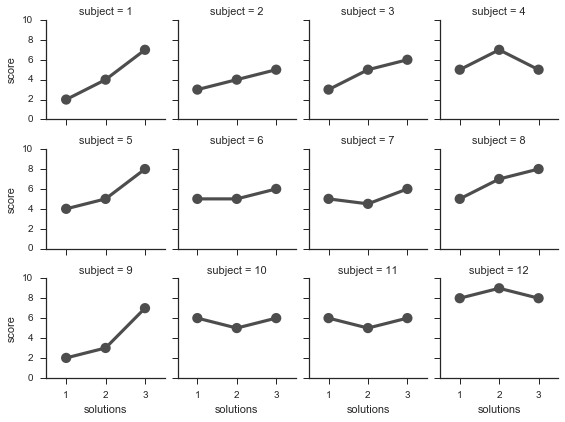

In [15]:
attend = sns.load_dataset("attention").query("subject <= 12")
g = sns.FacetGrid(attend, col="subject", col_wrap=4, size=2, ylim=(0, 10))
g.map(sns.pointplot, "solutions", "score", color=".3", ci=None)

Once you've drawn a plot using :meth:`FacetGrid.map` (which can be called multiple times), you may want to adjust some aspects of the plot. There are also a number of methods on the `FacetGrid` object for manipulating the figure at a higher level of abstraction. The most general is :meth:`FacetGrid.set`, and there are other more specialized methods like :meth:`FacetGrid.set_axis_labels`, which respects the fact that interior facets do not have axis labels. For example:

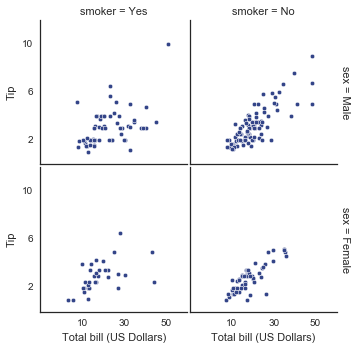

In [16]:
with sns.axes_style("white"):
    g = sns.FacetGrid(tips, row="sex", col="smoker", margin_titles=True, size=2.5)
g.map(plt.scatter, "total_bill", "tip", color="#334488", edgecolor="white", lw=.5);
g.set_axis_labels("Total bill (US Dollars)", "Tip");
g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])
g.fig.subplots_adjust(wspace=.02, hspace=.02)

For even more customization, you can  work directly with the underling matplotlib ``Figure`` and ``Axes`` objects, which are stored as member attributes at ``fig`` and ``axes`` (a two-dimensional array), respectively. When making a figure without row or column faceting, you can also use the ``ax`` attribute to directly access the single axes.

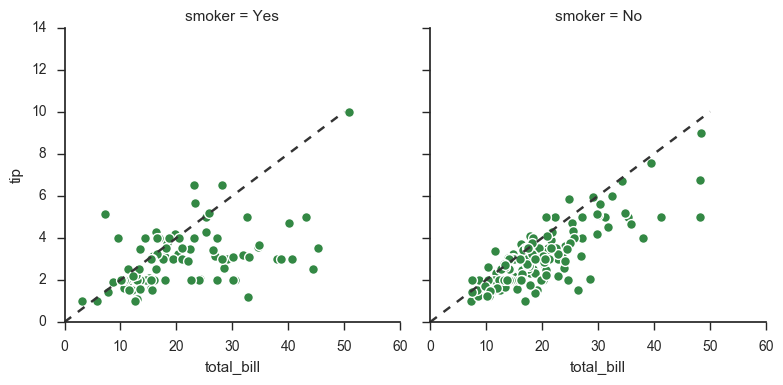

In [16]:
g = sns.FacetGrid(tips, col="smoker", margin_titles=True, size=4)
g.map(plt.scatter, "total_bill", "tip", color="#338844", edgecolor="white", s=50, lw=1)
for ax in g.axes.flat:
    ax.plot((0, 50), (0, .2 * 50), c=".2", ls="--")
g.set(xlim=(0, 60), ylim=(0, 14))

### Mapping custom functions onto the grid

You're not limited to existing matplotlib and seaborn functions when using `FacetGrid`. However, to work properly, any function you use must follow a few rules:

1. It must plot onto the "currently active" matplotlib ``Axes``. This will be true of functions in the ``matplotlib.pyplot`` namespace, and you can call ``plt.gca`` to get a reference to the current ``Axes`` if you want to work directly with its methods.
2. It must accept the data that it plots in positional arguments. Internally, `FacetGrid` will pass a ``Series`` of data for each of the named positional arguments passed to :meth:`FacetGrid.map`.
3. It must be able to accept ``color`` and ``label`` keyword arguments, and, ideally, it will do something useful with them. In most cases, it's easiest to catch a generic dictionary of ``**kwargs`` and pass it along to the underlying plotting function.

Let's look at minimal example of a function you can plot with. This function will just take a single vector of data for each facet:

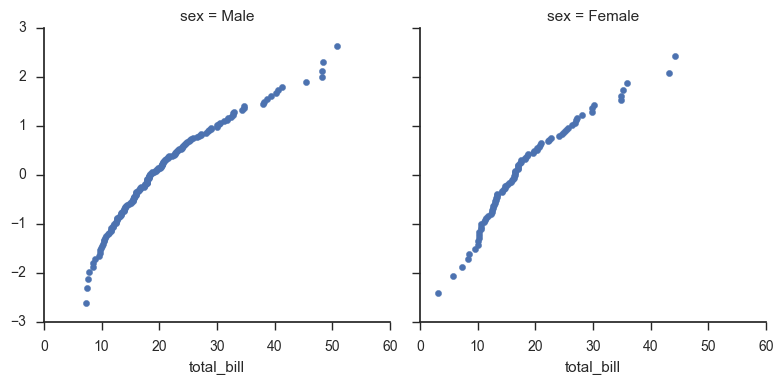

In [17]:
def quantile_plot(x, **kwargs):
    qntls, xr = stats.probplot(x, fit=False)
    plt.scatter(xr, qntls, **kwargs)
    
g = sns.FacetGrid(tips, col="sex", size=4)
g.map(quantile_plot, "total_bill")

If we want to make a bivariate plot, you should write the function so that it accepts the x-axis variable first and the y-axis variable second:

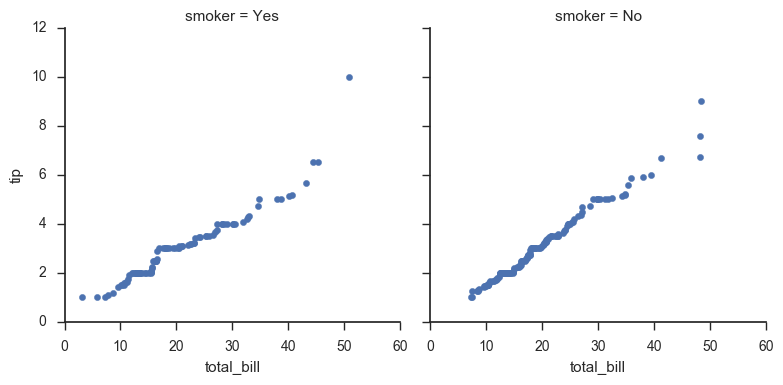

In [18]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)
    
g = sns.FacetGrid(tips, col="smoker", size=4)
g.map(qqplot, "total_bill", "tip")

Because ``plt.scatter`` accepts ``color`` and ``label`` keyword arguments and does the right thing with them, we can add a hue facet without any difficulty:

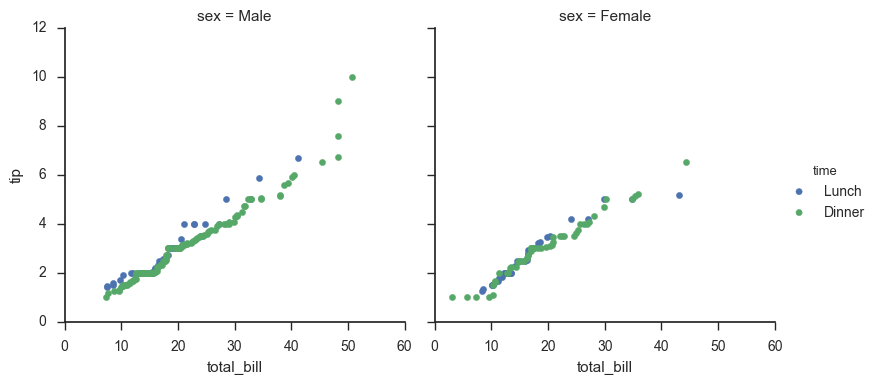

In [19]:
g = sns.FacetGrid(tips, hue="time", col="sex", size=4)
g.map(qqplot, "total_bill", "tip")
g.add_legend()

This approach also lets us use additional aesthetics to distinguish the levels of the hue variable, along with keyword arguments that won't be depdendent on the faceting variables:

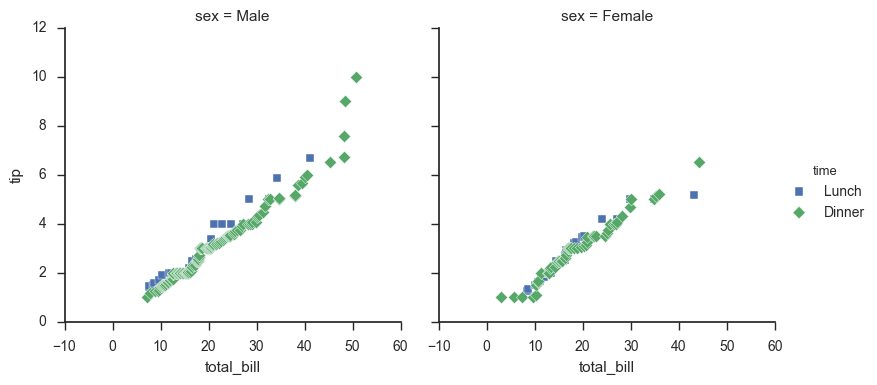

In [20]:
g = sns.FacetGrid(tips, hue="time", col="sex", size=4,
                  hue_kws={"marker": ["s", "D"]})
g.map(qqplot, "total_bill", "tip", s=40, edgecolor="w")
g.add_legend()

Sometimes, though, you'll want to map a function that doesn't work the way you expect with the ``color`` and ``label`` keyword arguments. In this case, you'll want to explictly catch them and handle them in the logic of your custom function. For example, this approach will allow use to map ``plt.hexbin``, which otherwise does not play well with the `FacetGrid` API:

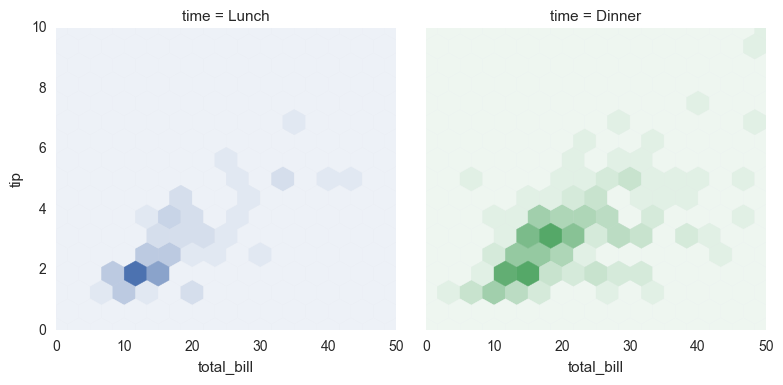

In [21]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(tips, hue="time", col="time", size=4)
g.map(hexbin, "total_bill", "tip", extent=[0, 50, 0, 10])

Plotting pairwise relationships with `PairGrid` and `pairplot`
---------------------------------------------------------------------------

`PairGrid` also allows you to quickly draw a grid of small subplots using the same plot type to visualize data in each. In a `PairGrid`, each row and column is assigned to a different variable, so the resulting plot shows each pairwise relationship in the dataset. This style of plot is sometimes called a "scatterplot matrix", as this is the most common way to show each relationship, but `PairGrid` is not limited to scatterplots.

It's important to understand the differences between a `FacetGrid` and a `PairGrid`. In the former, each facet shows the same relationship conditioned on different levels of other variables. In the latter, each plot shows a different relationship (although the upper and lower triangles will have mirrored plots). Using `PairGrid` can give you a very quick, very high-level summary of interesting relationships in your dataset.

The basic usage of the class is very similar to `FacetGrid`. First you initialize the grid, then you pass plotting function to a ``map`` method and it will be called on each subplot. There is also a companion function, `pairplot` that trades off some flexibility for faster plotting.

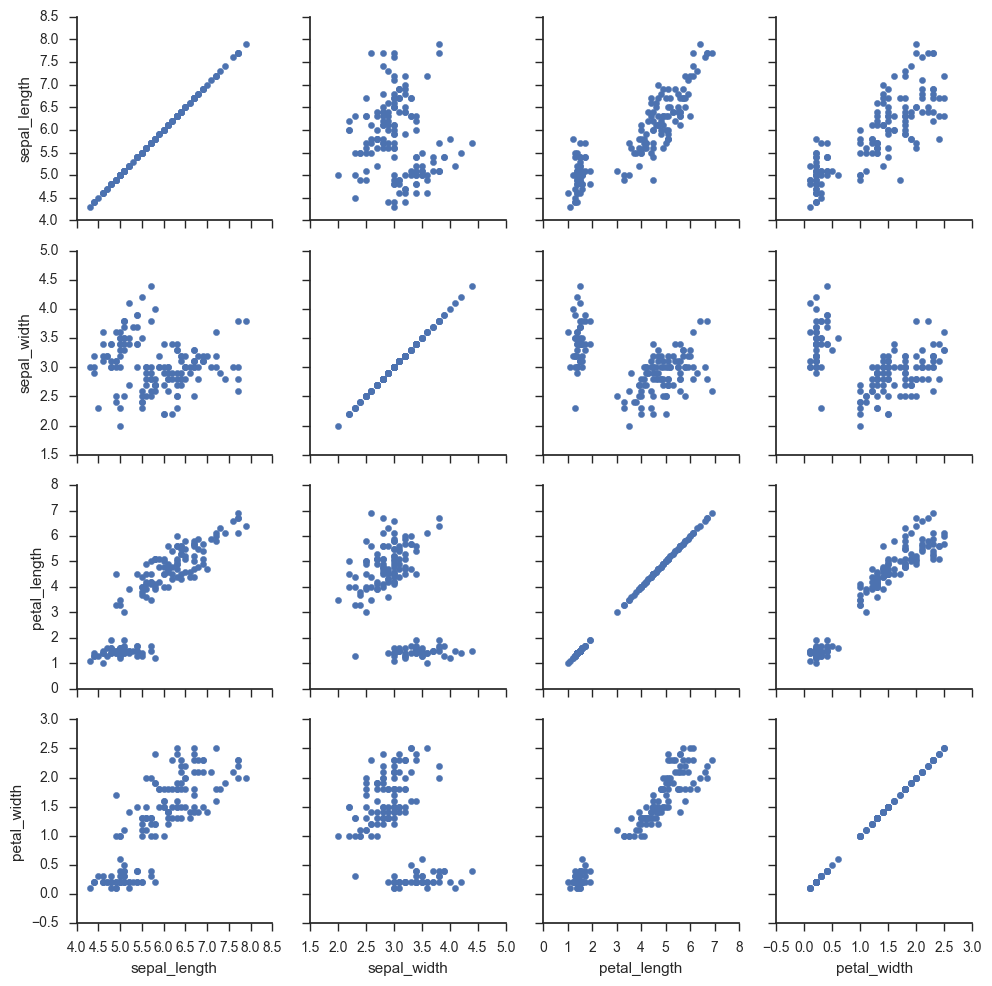

In [22]:
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris)
g.map(plt.scatter)

It's possible to plot a different function on the diagonal to show the univariate distribution of the variable in each column. Note that the axis ticks won't correspond to the count or density axis of this plot, though.

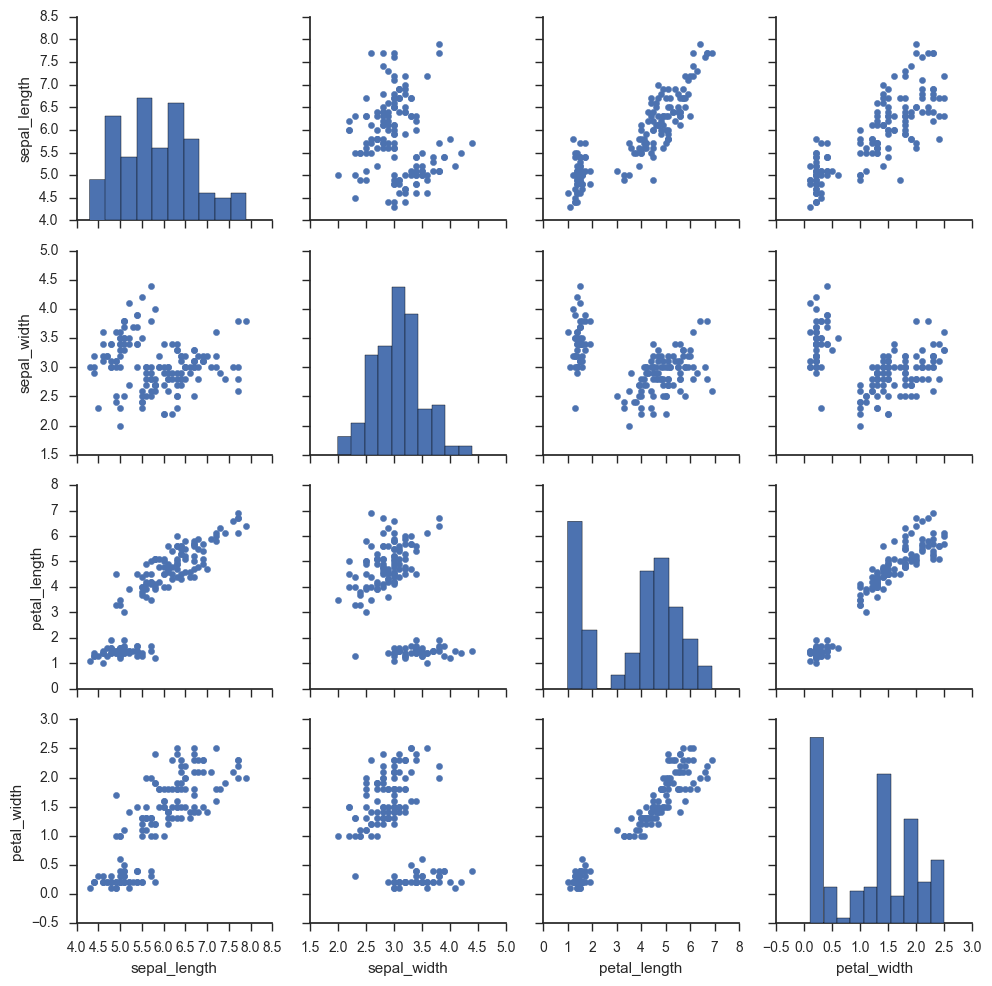

In [23]:
g = sns.PairGrid(iris)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

A very common way to use this plot colors the observations by a separate categorical variable. For example, the iris dataset has four measurements for each of three different species of iris flowers so you can see how they differ.

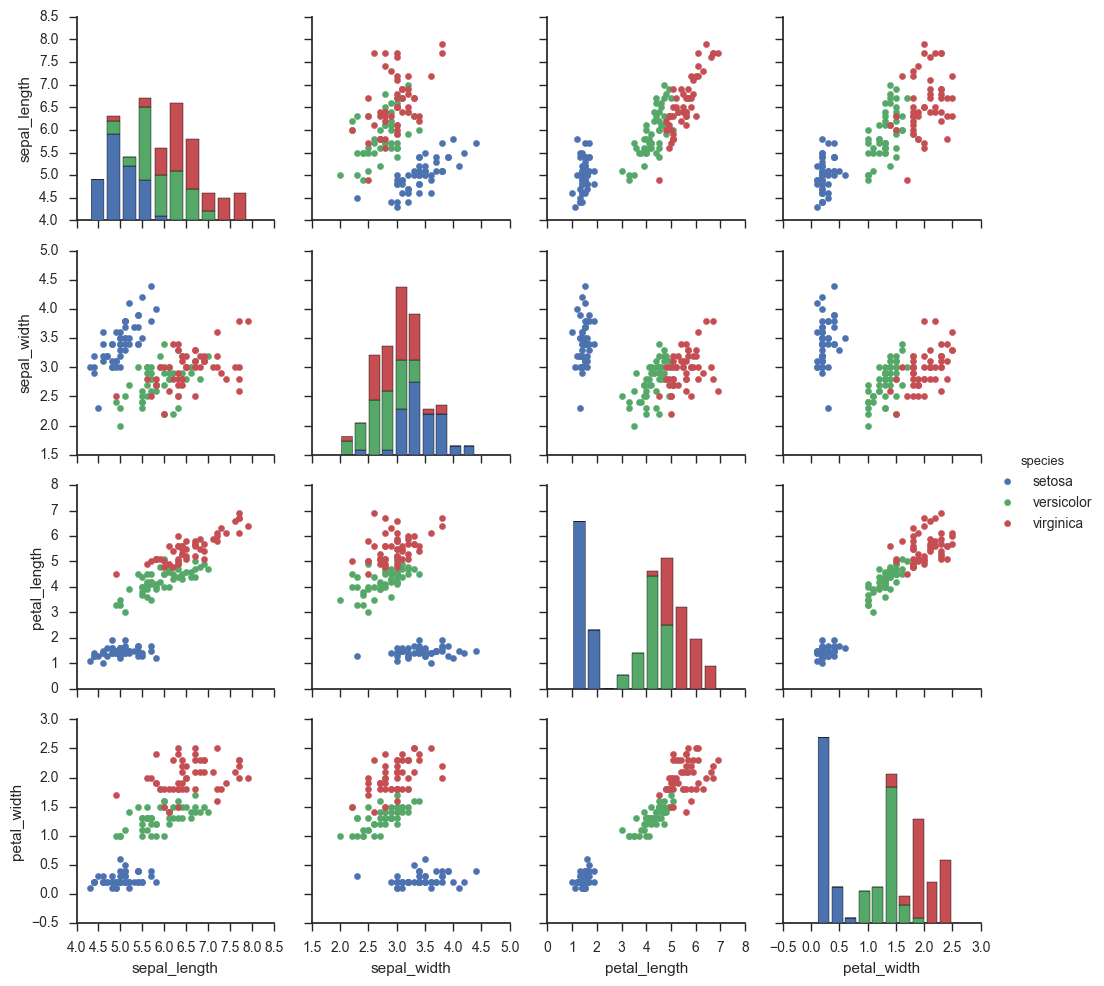

In [24]:
g = sns.PairGrid(iris, hue="species")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

By default every numeric column in the dataset is used, but you can focus on particular relationships if you want.

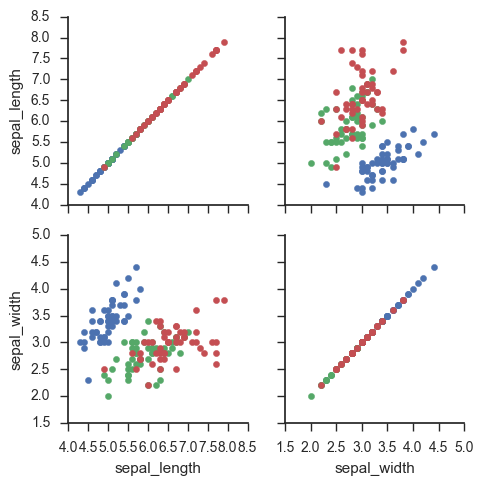

In [25]:
g = sns.PairGrid(iris, vars=["sepal_length", "sepal_width"], hue="species")
g.map(plt.scatter)

It's also possible to use a different function in the upper and lower triangles to emphasize different aspects of the relationship.

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


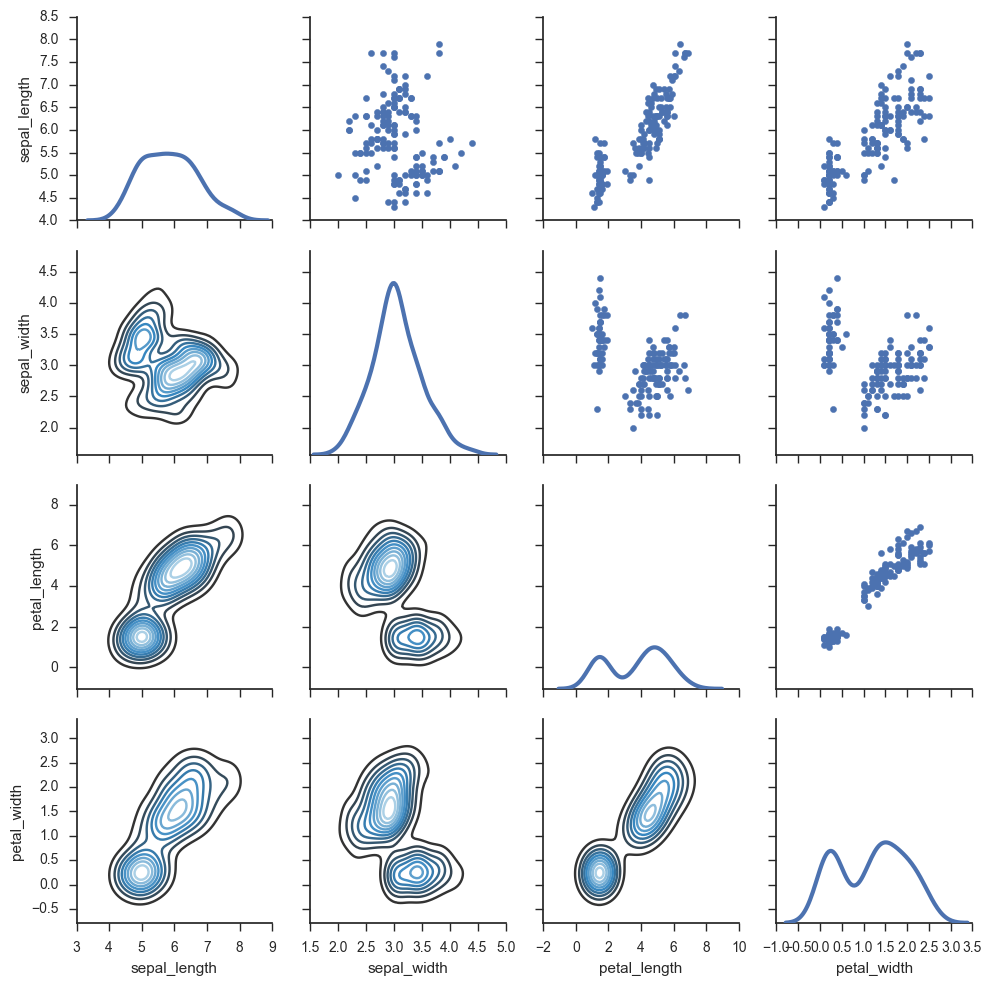

In [26]:
g = sns.PairGrid(iris)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False)

The square grid with identity relationships on the diagonal is actually just a special case, and you can plot with different variables in the rows and columns.

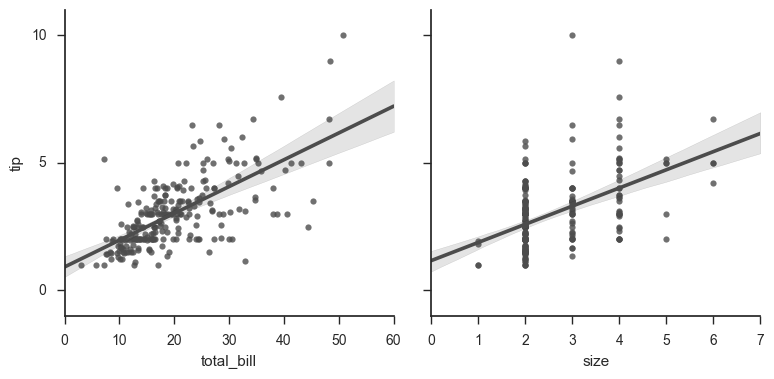

In [27]:
g = sns.PairGrid(tips, y_vars=["tip"], x_vars=["total_bill", "size"], size=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-1, 11), yticks=[0, 5, 10])

Of course, the aesthetic attributes are configurable. For instance, you can use a different palette (say, to show an ordering of the ``hue`` variable) and pass keyword arguments into the plotting functions.

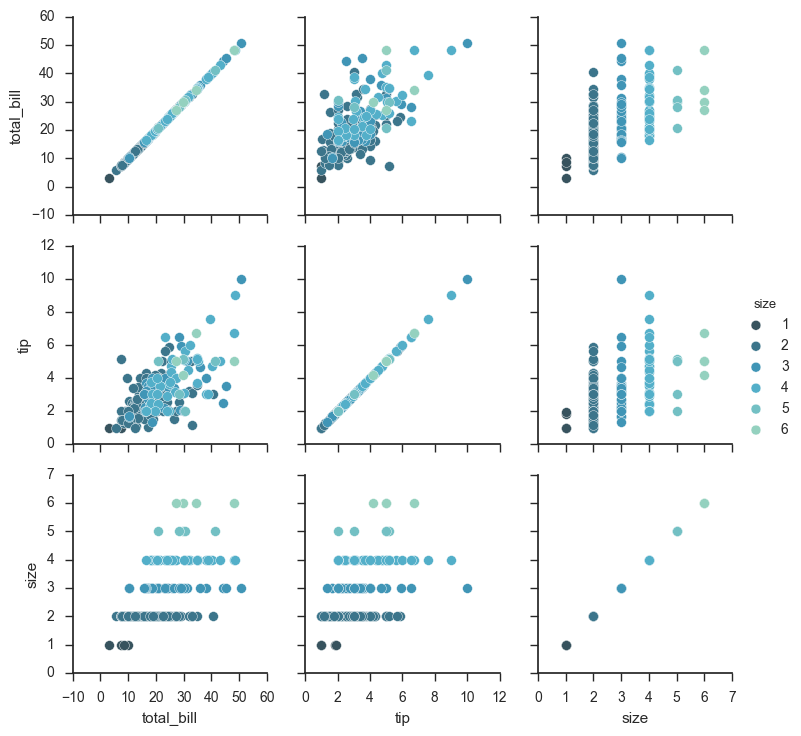

In [28]:
g = sns.PairGrid(tips, hue="size", palette="GnBu_d")
g.map(plt.scatter, s=50, edgecolor="white")
g.add_legend()

`PairGrid` is flexible, but to take a quick look at a dataset, it can be easier to use `pairplot`. This function uses scatterplots and histograms by default, although a few other kinds will be added (currently, you can also plot regression plots on the off-diagonals and KDEs on the diagonal).

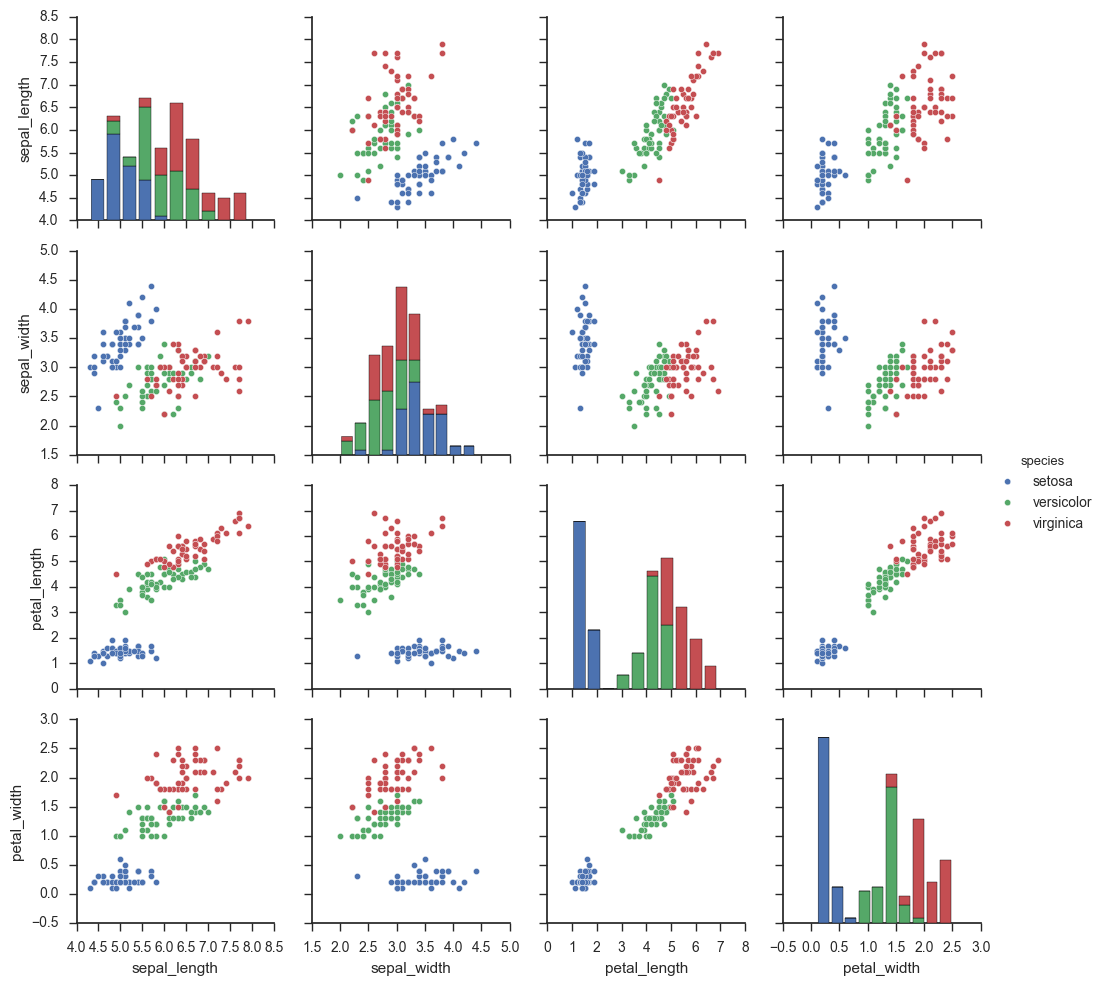

In [29]:
sns.pairplot(iris, hue="species", size=2.5)

You can also control the aesthetics of the plot with keyword arguments, and it returns the `PairGrid` instance for further tweaking.

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


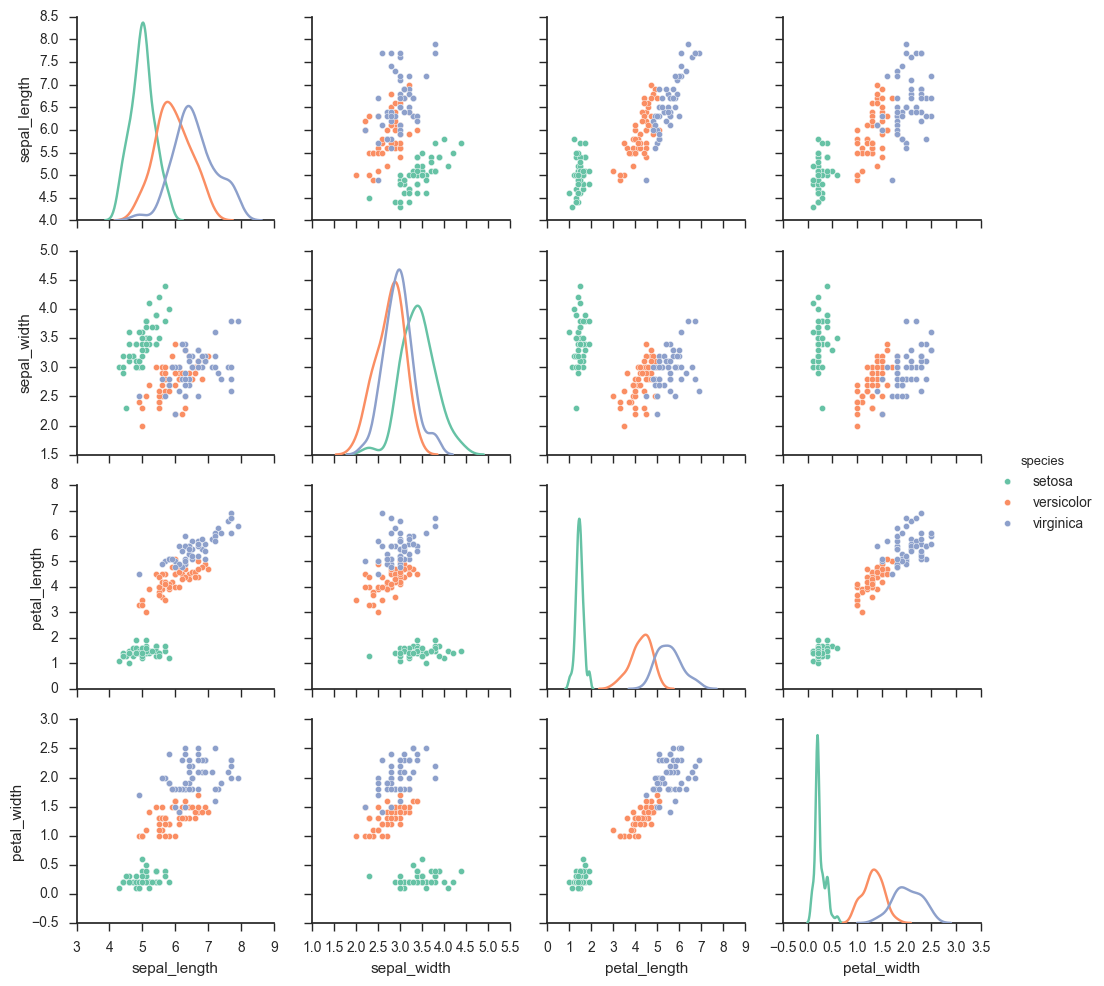

In [30]:
g = sns.pairplot(iris, hue="species", palette="Set2", diag_kind="kde", size=2.5)